In [37]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, Image as IPImage

from PIL import Image

from ipywidgets import interact, Dropdown, IntText

import cv2
from skimage import feature
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import numpy as np

from MirrorExtractor.mirror_extractor import MirrorExtractor

from sklearn.ensemble import IsolationForest

In [31]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def compute_mirror_features(mirror_list):
    """
    Oblicza cechy dla każdego lustra
    """
    features = []
    
    for mirror in mirror_list:
        feature_dict = {}
        
        # 1. Statystyki podstawowe dla każdego kanału RGB
        for i, color in enumerate(['R', 'G', 'B']):
            feature_dict[f'{color}_mean'] = np.mean(mirror[:, :, i])
            feature_dict[f'{color}_std'] = np.std(mirror[:, :, i])
            feature_dict[f'{color}_median'] = np.median(mirror[:, :, i])
            feature_dict[f'{color}_min'] = np.min(mirror[:, :, i])
            feature_dict[f'{color}_max'] = np.max(mirror[:, :, i])
        
        # 2. Jasność ogólna
        feature_dict['brightness'] = np.mean(mirror)
        feature_dict['brightness_std'] = np.std(mirror)
        
        # 3. Kontrast
        feature_dict['contrast'] = np.std(mirror)
        
        # 4. Entropia (miara "chaotyczności")
        hist, _ = np.histogram(mirror.flatten(), bins=256, range=(0, 256))
        hist = hist / hist.sum()
        hist = hist[hist > 0]
        feature_dict['entropy'] = -np.sum(hist * np.log2(hist))
        
        # 5. Dominujący kolor (RGB)
        feature_dict['dominant_R'] = np.percentile(mirror[:, :, 0], 75)
        feature_dict['dominant_G'] = np.percentile(mirror[:, :, 1], 75)
        feature_dict['dominant_B'] = np.percentile(mirror[:, :, 2], 75)
        
        # 6. Gradient (wykrywa krawędzie/wzory)
        gray = np.mean(mirror, axis=2)
        gradient_x = np.gradient(gray, axis=1)
        gradient_y = np.gradient(gray, axis=0)
        feature_dict['gradient_magnitude'] = np.mean(np.sqrt(gradient_x**2 + gradient_y**2))
        
        # 7. Liczba pikseli bardzo jasnych i bardzo ciemnych
        feature_dict['very_bright_ratio'] = np.sum(mirror > 200) / mirror.size
        feature_dict['very_dark_ratio'] = np.sum(mirror < 50) / mirror.size
        
        features.append(feature_dict)
    
    return features



In [23]:
def show_image(image_path, mirror_id):
    img = Image.open(image_path)
    x_coords, y_coords = extractor.get_coords(mirror_id)
    
    plt.figure(figsize=(10, 8))
    plt.plot(x_coords, y_coords, 'r-', lw=2)
    plt.scatter(x_coords[:-1], y_coords[:-1], c='cyan', s=30)
    plt.imshow(img)
    plt.axis('off')
    text_title = image_path.split('/')[-1] + "mirror id:" + str(mirror_id)
    plt.title(text_title)
    plt.show()

In [6]:
! pwd

/home/pgliwny/Praca/Computer_vision_for_MAGIC/notebooks


In [25]:
img_path = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2023-01-01_1200.jpg"
img_path_adata = "/media/pgliwny/ADATA HD3303/Computer_Vision_system/data/MAGIC/IRCam/IRCamera/2025/08/15/IRCamM1T20250815_095000M.jpg"


In [22]:
 extractor = MirrorExtractor("/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/crossings_points.pkl")

In [12]:
img_list = glob.glob("/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/*.jpg")
print(img_list[:5])

['/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg', '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2023-01-04_1600.jpg', '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-07_1600.jpg', '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-04_1000.jpg', '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-21_1700.jpg']


In [36]:
interact(
    show_image,
    image_path=Dropdown(
        options=sorted(img_list[:]),
        description='Select:'
    ),
     mirror_id=IntText(
        value=0,
        min=0,
        max=250,
        step=1,
        description='ID:'
    )
)

interactive(children=(Dropdown(description='Select:', options=('/home/pgliwny/Praca/Computer_vision_for_MAGIC/…

<function __main__.show_image(image_path, mirror_id)>

In [29]:
def extract_one_mirror_from_images(img_path_list, mirror_id, extractor):
    mirror_list = []
    for path in img_path_list:
        img = np.array(Image.open(path).convert('RGB'))
        x_coords, y_coords = extractor.get_coords(mirror_id)
        cropped = extractor.extract_polygon_region_cv2(img, x_coords, y_coords)
        mirror_list.append(cropped)
    return mirror_list

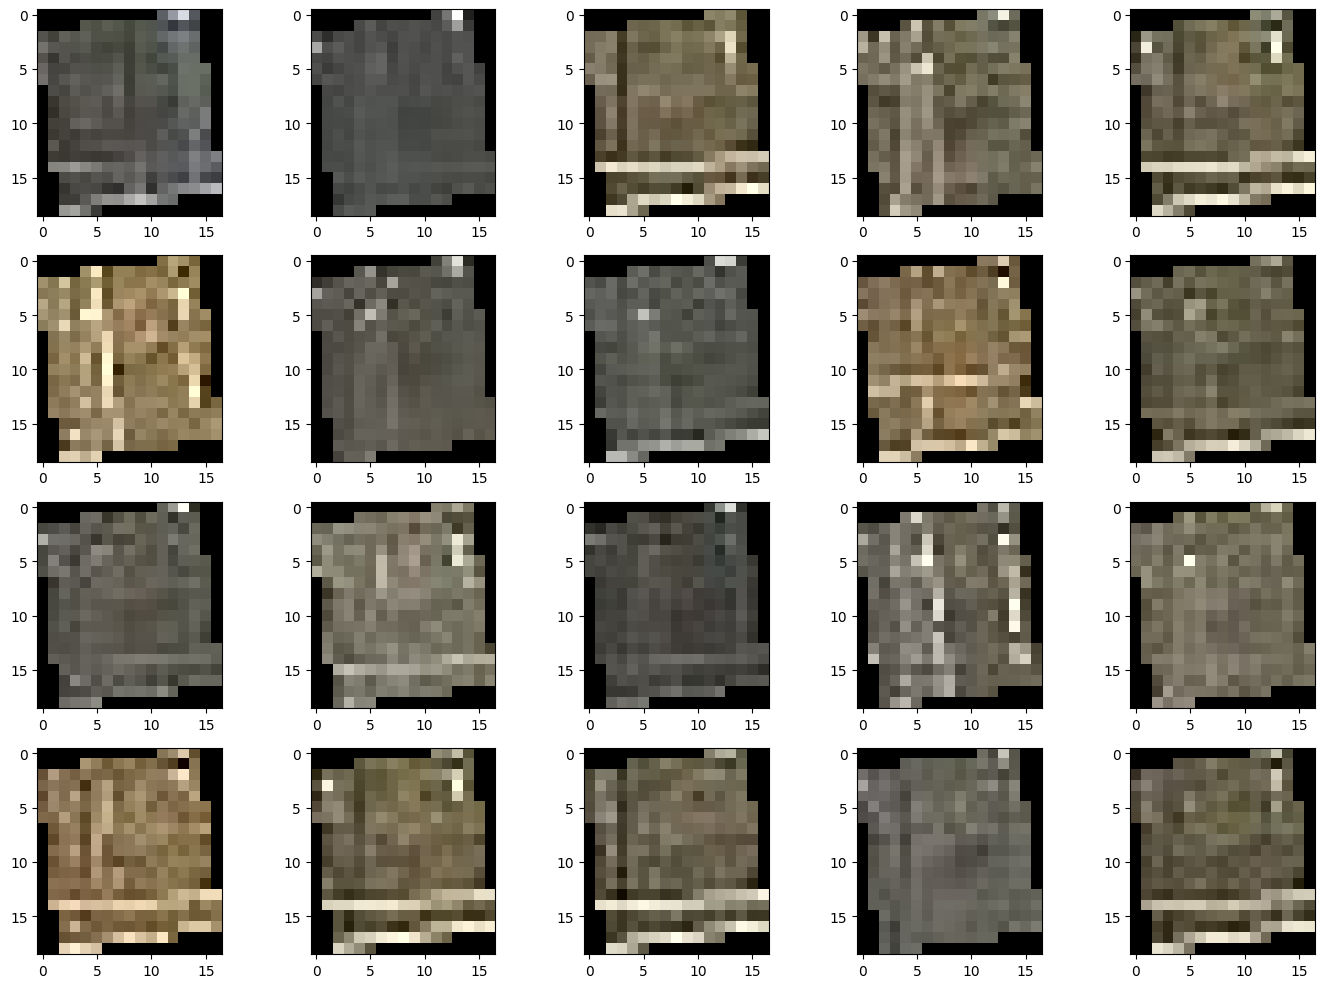

In [41]:
mirror_list = extract_one_mirror_from_images(img_list[:], 150, extractor)

fig, ax = plt.subplots(4, 5, figsize=(14, 10))
axes = ax.flatten()
for i in range(20):
    axes[i].imshow(mirror_list[i])

plt.tight_layout()

In [32]:
path_list = [path.split("/")[-1] for path in img_list]
mirror_features = compute_mirror_features(mirror_list)
df_mirror_features = pd.DataFrame(mirror_features)
df_mirror_features["name"] = path_list[:]
df_mirror_features.head()

,R_mean,R_std,R_median,R_min,R_max,G_mean,G_std,G_median,G_min,G_max,...,brightness_std,contrast,entropy,dominant_R,dominant_G,dominant_B,gradient_magnitude,very_bright_ratio,very_dark_ratio,name
0,100.882353,62.382544,93.0,0,255,106.904412,63.863351,97.0,0,255,...,64.120329,64.120329,6.551588,121.25,124.75,122.25,46.320801,0.110294,0.125000,image_2024-05-09_1500.jpg
1,129.944853,53.038837,148.0,0,233,145.352941,59.522058,168.5,0,245,...,59.505990,59.505990,6.505643,164.00,183.25,192.00,39.330297,0.064951,0.115196,image_2023-01-04_1600.jpg
2,109.860294,55.514462,113.0,0,248,110.503676,57.474483,110.0,0,255,...,57.290126,57.290126,6.634583,129.00,125.25,99.00,47.086433,0.080882,0.126225,image_2024-05-07_1600.jpg
3,180.628676,78.775264,212.0,0,255,190.669118,82.064766,232.0,0,255,...,81.669185,81.669185,6.149757,237.25,251.00,252.25,49.871683,0.627451,0.116422,image_2024-05-04_1000.jpg
4,161.812500,70.336728,185.0,0,248,174.242647,74.269877,202.0,0,255,...,74.108201,74.108201,6.661788,208.00,221.00,226.00,48.522323,0.482843,0.113971,image_2024-05-21_1700.jpg


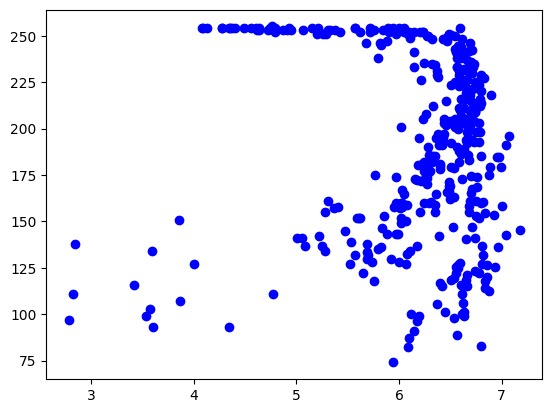

In [33]:
plt.plot(df_mirror_features["entropy"], df_mirror_features["dominant_B"], 'bo')

In [35]:
df_mirror_features[df_mirror_features["entropy"]<4]


,R_mean,R_std,R_median,R_min,R_max,G_mean,G_std,G_median,G_min,G_max,...,brightness_std,contrast,entropy,dominant_R,dominant_G,dominant_B,gradient_magnitude,very_bright_ratio,very_dark_ratio,name
31,83.102941,29.854495,94.0,0,96,87.533088,31.440870,99.0,0,101,...,31.383427,31.383427,3.573714,95.0,100.00,103.0,17.909186,0.0,0.113971,image_2024-01-19_1000.jpg
71,84.327206,30.271436,95.0,0,99,86.187500,30.935027,97.0,0,101,...,30.618614,30.618614,2.784078,96.0,98.00,97.0,17.897251,0.0,0.113971,image_2024-01-19_1200.jpg
77,125.966912,45.184455,142.0,0,143,126.941176,45.531625,143.0,0,145,...,44.843810,44.843810,2.843408,143.0,144.00,138.0,25.558506,0.0,0.113971,image_2023-01-31_1000.jpg
240,93.481618,33.727711,106.0,0,117,95.595588,34.429783,108.0,0,119,...,33.866166,33.866166,3.866013,108.0,109.00,107.0,20.235773,0.0,0.113971,image_2023-01-31_1100.jpg
247,99.323529,35.630742,112.0,0,116,101.095588,36.266148,114.0,0,118,...,35.737906,35.737906,2.822138,112.0,114.00,111.0,20.460241,0.0,0.113971,image_2024-01-19_1300.jpg
250,100.073529,35.962528,113.0,0,121,101.643382,36.521569,115.0,0,123,...,36.295658,36.295658,3.422571,114.0,116.00,116.0,21.092043,0.0,0.113971,image_2023-01-03_1300.jpg
279,83.768382,30.137699,94.0,0,113,88.150735,31.674634,99.0,0,117,...,31.071569,31.071569,3.539763,96.0,100.00,99.0,18.277829,0.0,0.113971,image_2024-01-19_1100.jpg
350,129.731618,46.620393,147.0,0,154,133.275735,47.889054,151.0,0,158,...,47.387445,47.387445,3.859600,148.0,152.00,151.0,27.631883,0.0,0.113971,image_2023-01-03_1100.jpg
359,115.911765,41.684383,131.0,0,135,117.875000,42.382092,133.0,0,139,...,42.052495,42.052495,3.591099,133.0,135.00,134.0,24.478134,0.0,0.113971,image_2023-01-03_1400.jpg
370,79.426471,28.612172,89.0,0,103,82.080882,29.516086,92.0,0,105,...,29.148661,29.148661,3.603076,91.0,93.25,93.0,17.316489,0.0,0.113971,image_2024-01-20_1100.jpg


In [40]:
# Wybierz kolumny do analizy
features = ['R_mean', 'R_std', 'R_median', 'G_mean', 'G_std',
            'G_median', 'B_mean', 'B_std', 'B_median', 
            'brightness', 'brightness_std', 'contrast', 'entropy',
            'dominant_R', 'dominant_G', 'dominant_B', 'gradient_magnitude',
            'very_bright_ratio', 'very_dark_ratio']

df_features = df_mirror_features[features]

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df_features)

# Dodaj kolumnę z wynikami (-1 = outlier, 1 = normalny)
df_mirror_features['is_outlier'] = outliers

# Pokaż outliery
outlier_rows = df_mirror_features[df_mirror_features['is_outlier'] == -1]
print(f"Znaleziono {len(outlier_rows)} outlierów")
outlier_rows

Znaleziono 19 outlierów


,R_mean,R_std,R_median,R_min,R_max,G_mean,G_std,G_median,G_min,G_max,...,contrast,entropy,dominant_R,dominant_G,dominant_B,gradient_magnitude,very_bright_ratio,very_dark_ratio,name,is_outlier
31,83.102941,29.854495,94.0,0,96,87.533088,31.440870,99.0,0,101,...,31.383427,3.573714,95.00,100.00,103.00,17.909186,0.000000,0.113971,image_2024-01-19_1000.jpg,-1
63,108.768382,47.278913,119.0,0,230,97.205882,44.893275,103.0,0,231,...,46.588660,6.562069,134.00,118.25,89.00,36.726055,0.014706,0.139706,image_2024-01-29_1800.jpg,-1
67,71.297794,39.151895,70.0,0,185,77.555147,41.759605,75.0,0,193,...,41.803547,6.101409,80.00,88.00,87.00,36.060614,0.001225,0.150735,image_2024-05-08_1600.jpg,-1
71,84.327206,30.271436,95.0,0,99,86.187500,30.935027,97.0,0,101,...,30.618614,2.784078,96.00,98.00,97.00,17.897251,0.000000,0.113971,image_2024-01-19_1200.jpg,-1
97,140.492647,79.905919,128.0,0,255,136.334559,81.127545,122.0,0,255,...,81.421727,7.044755,218.00,211.00,191.25,75.345944,0.272059,0.154412,image_2024-05-10_1800.jpg,-1
103,74.841912,43.599287,72.0,0,202,82.132353,46.478459,78.0,0,219,...,46.571757,6.145197,81.00,89.00,91.00,40.826908,0.017157,0.147059,image_2024-05-08_1000.jpg,-1
132,81.735294,41.275569,84.0,0,182,88.360294,44.977065,86.0,0,204,...,45.049745,6.199041,95.00,99.00,99.25,39.398536,0.012255,0.128676,image_2024-05-08_1300.jpg,-1
133,66.106618,38.776410,62.0,0,166,71.735294,40.970440,67.0,0,182,...,40.768117,5.941164,73.00,78.00,74.00,35.268329,0.000000,0.181373,image_2024-05-08_1200.jpg,-1
172,77.974265,39.020772,78.0,0,178,84.922794,42.214760,83.5,0,191,...,42.729549,6.171595,89.25,99.00,96.25,36.858767,0.001225,0.125000,image_2024-05-08_1400.jpg,-1
199,80.808824,36.004292,86.0,0,166,86.977941,38.635736,90.0,0,175,...,38.603625,6.120817,96.00,102.25,100.25,33.319888,0.000000,0.123775,image_2024-05-08_1100.jpg,-1
